<a href="https://colab.research.google.com/github/LucasHenrique-dev/RECPAD-2025.2/blob/main/RECPAD_modelo_Linear_Nao_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar Dependências

In [1]:
!pip install autorank
!pip install interpret -q

# Importar Bibliotecas

In [2]:
import os
import io
import json
import time
import math
import shutil
import zipfile
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from contextlib import redirect_stdout
from sklearn.impute import SimpleImputer
from scipy.stats import uniform, randint
from IPython.display import display, HTML
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import FitFailedWarning
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from autorank import autorank, plot_stats, create_report, latex_table
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.datasets import make_friedman1, fetch_california_housing, load_diabetes
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error, explained_variance_score
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from interpret.glassbox import ExplainableBoostingRegressor

# Configurações

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore", category=FutureWarning)

OUT_DIR = 'resultados_pesquisa'
N_OUTER_FOLDS = 3 # Número de testes por base de dados
N_INNER_ITERATIONS = 3 # RandomizedSearch
STATS_DIR = "statistical_analysis_reports"

TEST_SIZE = 0.2
VISUAL_REPORT_DIR = 'visual_analysis_report'

DATASET_PARA_PLOTAR = 'concrete'

# Bases de Dados

In [4]:
# @title ##Carregar Bases de Dados


def download_file(url, dest_path):
    r = requests.get(url)
    r.raise_for_status()
    with open(dest_path, 'wb') as f:
        f.write(r.content)


def load_friedman(n_samples=1000, noise=1.0, random_state=RANDOM_STATE):
    X, y = make_friedman1(n_samples=n_samples, noise=noise, random_state=random_state)
    return pd.DataFrame(X, columns=[f'x{i}' for i in range(X.shape[1])]), pd.Series(y, name='target')

def load_california_housing():
    """ Carrega o dataset California Housing (scikit-learn). """
    data = fetch_california_housing()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name='target')
    return X, y

def load_diabete():
    """ Carrega o dataset Diabetes (scikit-learn). """
    data = load_diabetes()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name='target')
    return X, y

def load_yacht():
    """ Carrega o dataset Yacht Hydrodynamics (UCI). """
    # https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data'
    dest = 'yacht_hydrodynamics.data'
    if not os.path.exists(dest):
        download_file(url, dest)

    # Dataset é separado por espaço, sem cabeçalho
    df = pd.read_csv(dest, delim_whitespace=True, header=None)

    # Nomes das colunas conforme a descrição do dataset
    col_names = [
        'long_pos_center_of_buoyancy', 'prismatic_coeff', 'length_disp_ratio',
        'beam_drought_ratio', 'length_beam_ratio', 'froude_number', 'residuary_resistance'
    ]
    df.columns = col_names

    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    X.columns = [f'x{i}' for i in range(X.shape[1])]
    y.name = 'target'
    return X, y

def load_advertising():
    """ Carrega o dataset Advertising (de um repositório confiável). """
    # Famoso dataset do livro ISLR
    url = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Advertising.csv'
    dest = 'Advertising.csv'
    if not os.path.exists(dest):
        download_file(url, dest)

    df = pd.read_csv(dest, index_col=0) # A primeira coluna é um índice

    # Features: TV, Radio, Newspaper. Alvo: Sales
    X = df[['TV', 'Radio', 'Newspaper']].copy()
    y = df['Sales'].copy()
    X.columns = [f'x{i}' for i in range(X.shape[1])]
    y.name = 'target'
    return X, y

def load_medical_cost():
    """ Carrega o dataset Medical Cost (Kaggle). """
    # Link direto para um raw CSV de uma versão popular no GitHub
    url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'
    dest = 'insurance.csv'
    if not os.path.exists(dest):
        download_file(url, dest)

    df = pd.read_csv(dest)

    # Alvo: charges
    X = df.drop('charges', axis=1)
    y = df['charges'].copy()
    # Os nomes das colunas originais (ex: 'smoker') são importantes aqui
    y.name = 'target'
    return X, y

def load_abalone():
    """ Carrega o dataset Abalone (UCI). """
    # https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
    dest = 'abalone.data'
    if not os.path.exists(dest):
        download_file(url, dest)

    # Nomes das colunas conforme a descrição do dataset
    col_names = [
        'Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
        'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'
    ]
    df = pd.read_csv(dest, header=None, names=col_names)

    # Alvo: Rings (idade)
    X = df.drop('Rings', axis=1)
    y = df['Rings'].copy()
    y.name = 'target'
    return X, y

def load_concrete():
    # https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls'
    dest = 'Concrete_Data.xls'
    if not os.path.exists(dest):
        download_file(url, dest)
    df = pd.read_excel(dest)
    # Last column is 'Concrete compressive strength' according to dataset
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    X.columns = [f'x{i}' for i in range(X.shape[1])]
    y.name = 'target'
    return X, y


def load_energy():
    # ENB2012_data.xlsx
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
    dest = 'ENB2012_data.xlsx'
    if not os.path.exists(dest):
        download_file(url, dest)
    df = pd.read_excel(dest)
    # Columns: X1..X8, Y1=Heating load, Y2=Cooling load
    # We'll predict Heating load (Y1) by default
    X = df.iloc[:, :-2].copy()
    y = df.iloc[:, -2].copy()
    X.columns = [f'x{i}' for i in range(X.shape[1])]
    y.name = 'target'
    return X, y


def load_airfoil():
    # airfoil_self_noise.dat
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
    dest = 'airfoil_self_noise.dat'
    if not os.path.exists(dest):
        download_file(url, dest)
    # whitespace-separated file with 6 columns (last is target)
    df = pd.read_csv(dest, sep='\t', header=None, comment='!')
    # sometimes sep is whitespace
    if df.shape[1] == 1:
        df = pd.read_csv(dest, sep='\\s+', header=None, comment='!')
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    X.columns = [f'x{i}' for i in range(X.shape[1])]
    y.name = 'target'
    return X, y


def load_ccpp():
    # CCPP dataset zip contains 'Folds5x2_pp.xlsx'
    zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip'
    zip_dest = 'CCPP.zip'
    if not os.path.exists(zip_dest):
        download_file(zip_url, zip_dest)
    with zipfile.ZipFile(zip_dest, 'r') as z:
        names = z.namelist()
        # find xlsx file
        xlsx_files = [n for n in names if n.lower().endswith('.xlsx')]
        if not xlsx_files:
            raise RuntimeError('No xlsx found in CCPP.zip')
        xlsx_name = xlsx_files[0]
        with z.open(xlsx_name) as f:
            df = pd.read_excel(f)
    # last column usually 'PE' (net hourly electrical energy output)
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    X.columns = [f'x{i}' for i in range(X.shape[1])]
    y.name = 'target'
    return X, y

In [5]:
# @title ## Tratamento de Dados

def create_preprocessor(X_df):
    """
    Cria um ColumnTransformer generalista baseado nos dtypes de um DataFrame.

    Argumentos:
        X_df (pd.DataFrame): O DataFrame de features (usado para detectar tipos).

    Retorna:
        ColumnTransformer: Um pré-processador scikit-learn pronto para ser
                           colocado em um Pipeline.
    """
    # Identifica colunas pelos dtypes
    # Inclui 'category' e 'bool' para robustez
    numeric_features = X_df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_df.select_dtypes(include=['object', 'category', 'bool']).columns

    print(f"    [Preprocessor] Features numéricas detectadas: {len(numeric_features)}")
    print(f"    [Preprocessor] Features categóricas detectadas: {len(categorical_features)}")

    # Pipeline para features numéricas
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Robusto a outliers
        ('scaler', StandardScaler())
    ])

    # Pipeline para features categóricas
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Preenche NaNs categóricos
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # Ignora categorias raras no teste
    ])

    # Cria o ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Mantém colunas não especificadas (se houver)
    )

    return preprocessor

In [6]:
# @title ## Salvar Bases de Dados

DATASETS = {
    # SINTÉTICO
    # 'friedman': load_friedman(n_samples=200, noise=1.0),
    # 'friedman2': load_friedman(n_samples=100, noise=1.0),
    # 'friedman3': load_friedman(n_samples=50, noise=1.0),
    'friedman4': load_friedman(n_samples=30, noise=1.0),

    # LINEARES
    'diabetes': load_diabete(),
    'advertising': load_advertising(),

    # Mistos
    'medical_cost': load_medical_cost(),

    # PEQUENOS E RUIDOSOS
    'yacht': load_yacht(),
    # 'airfoil': load_airfoil(),

    # TAMANHO MÉDIO
    # 'california_housing': load_california_housing(),
    # 'concrete': load_concrete(),
    # 'abalone': load_abalone(),
    # 'ccpp': load_ccpp(),

    # GRANDE ESCALA

    # ALTA DIMENSÃO

    # 'energy': load_energy(), => Dois alvos: Y1 (Heating Load) e Y2 (Cooling Load)
}

# Modelos

In [7]:
# @title ## Modelo Proposto: Linear + Não Linear

class HybridRegressor:
    """
    Estimator that fits a linear regressor first, then fits a non-linear regressor
    on the residuals. Prediction = linear.predict(X) + nonlin.predict(X)
    This is sketched to behave like a scikit-learn estimator (fit, predict).
    """
    def __init__(self, linear, nonlin):
        self.linear = linear
        self.nonlin = nonlin

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        # fit linear
        self.linear.fit(X, y)

        # compute residuals on train
        y_lin_pred = self.linear.predict(X)
        resid = y - y_lin_pred

        # fit non-linear on residuals
        self.nonlin.fit(X, resid)

        return self

    def predict(self, X):
        X = np.asarray(X)

        lin_pred = self.linear.predict(X)
        resid_pred = self.nonlin.predict(X)

        return lin_pred + resid_pred

    def get_params(self, deep=True):
        return {"linear": self.linear, "nonlin": self.nonlin}

    def set_params(self, **params):
        for param, value in params.items():
            split = param.split('__', 1)
            if len(split) > 1:
                # Parâmetro aninhado (ex: 'linear__alpha')
                component_name, component_param = split
                if component_name in self.get_params(deep=False):
                    getattr(self, component_name).set_params(**{component_param: value})
            else:
                # Parâmetro do próprio HybridRegressor (ex: 'linear')
                setattr(self, param, value)
        return self

    # MÉTODO EXTRA PARA ANÁLISE DAS CONTRIBUIÇÕES INDIVIDUAIS
    def predict_components(self, X):
        """Retorna a predição final e seus componentes."""
        X = np.asarray(X)

        lin_pred = self.linear.predict(X)
        resid_pred = self.nonlin.predict(X)

        total_pred = lin_pred + resid_pred

        return total_pred, lin_pred, resid_pred

In [8]:
# @title ## Modelo Linear

class LinearRegressor:
    """
    Estimator that fits a linear regressor. Prediction = linear.predict(X)
    This is sketched to behave like a scikit-learn estimator (fit, predict).
    """
    def __init__(self, linear):
        self.linear = linear

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        # fit linear
        self.linear.fit(X, y)

        return self

    def predict(self, X):
        X = np.asarray(X)

        return self.linear.predict(X)

    def get_params(self, deep=True):
        return {"linear": self.linear}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)

        return self

In [9]:
# @title ## Modelo Não Linear

class NonLinearRegressor:
    """
    Estimator that fits a non-linear regressor. Prediction = nonlin.predict(X)
    This is sketched to behave like a scikit-learn estimator (fit, predict).
    """
    def __init__(self, nonlin):
        self.nonlin = nonlin

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        # fit non-linear
        self.nonlin.fit(X, y)

        return self

    def predict(self, X):
        X = np.asarray(X)

        return self.nonlin.predict(X)

    def get_params(self, deep=True):
        return {"nonlin": self.nonlin}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)

        return self

In [10]:
# @title ## Modelo Autor 1

In [11]:
# @title ## Modelo Autor 2 - A novel stacking ensemble learner for predicting residual strength of corroded pipelines

def criar_modelo_autor2():
    estimators = [
        ('ridge', Ridge(alpha=1.0, random_state=RANDOM_STATE)),
        ('xgb', XGBRegressor(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            random_state=RANDOM_STATE
        ))
    ]
    modelo = StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(random_state=RANDOM_STATE),
        cv=5,
        n_jobs=-1
    )
    return modelo

In [12]:
# @title ## Modelo Autor 3 (InterpretML - Explainable Boosting Machine)
from interpret.glassbox import ExplainableBoostingRegressor

def criar_modelo_autor3():
    """
    Cria o modelo Explainable Boosting Machine (EBM)
    envolto no NonLinearRegressor, mantendo o padrão dos outros modelos.
    """
    modelo = NonLinearRegressor(
        ExplainableBoostingRegressor(random_state=RANDOM_STATE)
    )

    # Usa dicionário vazio para compatibilidade com RandomizedSearchCV
    param_space = {}

    return modelo, param_space

In [13]:
# @title ## Definir Parâmetros

PARAM_SPACE_RIDGE_XGB = {
    # --- Parte Linear ---
    'model__linear__alpha': loguniform(1e-3, 1e3),

    # --- Parte Não-Linear (Resíduos) ---
    'model__nonlin__n_estimators': randint(50, 400),
    'model__nonlin__max_depth': randint(2, 8),
    'model__nonlin__learning_rate': loguniform(0.01, 0.3),
    'model__nonlin__subsample': uniform(loc=0.6, scale=0.4),
    'model__nonlin__colsample_bytree': uniform(loc=0.5, scale=0.5),
    'model__nonlin__gamma': uniform(loc=0, scale=0.5)
}

PARAM_SPACE_RIDGE = {
    'model__alpha': loguniform(1e-3, 1e3),
}

PARAM_SPACE_XGB = {
    'model__n_estimators': randint(50, 400),
    'model__max_depth': randint(2, 8),
    'model__learning_rate': loguniform(0.01, 0.3),
    'model__subsample': uniform(loc=0.6, scale=0.4),
    'model__colsample_bytree': uniform(loc=0.5, scale=0.5),
    'model__gamma': uniform(loc=0, scale=0.5)
}

PARAM_SPACE_STACKING = {
    'model__final_estimator__n_neighbors': randint(3, 8),
    'model__final_estimator__weights': ['uniform', 'distance']
}

In [14]:
# @title ## Definir Métricas

def evaluate_regression(y_true, y_pred):
    """
    Calcula um conjunto expandido de métricas de regressão
    para analisar diferentes aspectos do desempenho do modelo.
    """
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MedAE': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MaxError': max_error(y_true, y_pred),
        'ExplainedVariance': explained_variance_score(y_true, y_pred)
    }

In [15]:
# @title ## Salvar Modelos

MODELOS = [
    ('Hibrido_Ridge_XGBoost', HybridRegressor(
        linear=Ridge(random_state=RANDOM_STATE), nonlin=XGBRegressor(random_state=RANDOM_STATE)
      ),
     PARAM_SPACE_RIDGE_XGB),
    ('Modelo_Ridge', LinearRegressor(
        Ridge(random_state=RANDOM_STATE)
      ),
     PARAM_SPACE_RIDGE),
    ('Modelo_XGBoost', NonLinearRegressor(
        XGBRegressor(random_state=RANDOM_STATE, n_jobs=1)
      ),
     PARAM_SPACE_XGB),
    # ('Modelo_Autor2_Stacking', criar_modelo_autor2(), {}),

    # # Modelo InterpretML (EBM)
    # ('Modelo_Autor3_InterpretML', *criar_modelo_autor3())
]

# Teste de Hipótese

In [16]:
# @title ## Definir Validação Cruzada

def run_nested_cv(X, y, model, param_space, n_outer=5, n_inner_iter=40):
    """
    Executa uma validação cruzada aninhada (Nested Cross-Validation) real.

    Argumentos:
        X, y: Os dados
        model: A instância do estimador scikit-learn, ex: Ridge()
        param_space: O dicionário de distribuições de parâmetros para o RandomizedSearch
        n_outer: Número de folds para o loop de avaliação externo
        n_inner_iter: Número de iterações para o RandomizedSearchCV
    """
    # Garante que X e y sejam arrays numpy para indexação
    if isinstance(X, pd.DataFrame): X = X.values
    if isinstance(y, pd.Series): y = y.values

    outer_cv = KFold(n_splits=n_outer, shuffle=True, random_state=42)

    all_fold_metrics = []

    # Loop Externo (Avaliação)
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        # print(f"  -> Outer Fold {i+1}/{n_outer}...") # Descomente para debug
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Clona o modelo base para garantir que o tuning seja limpo
        model_clone = clone(model)

        # Loop Interno (Tuning de Hiperparâmetros)
        # O CV interno pode ser menor (ex: 3 folds)
        inner_cv_search = RandomizedSearchCV(
            estimator=model_clone,
            param_distributions=param_space,
            n_iter=n_inner_iter,
            cv=3,
            scoring='neg_root_mean_squared_error', # Otimiza para RMSE
            n_jobs=-1,
            random_state=42,
            verbose=0 # Mude para 1 ou 2 para mais detalhes
        )

        # Encontra os melhores parâmetros no conjunto de treino externo
        inner_search_result = inner_cv_search.fit(X_train, y_train)

        # Pega o melhor modelo treinado
        best_model = inner_search_result.best_estimator_

        # Avalia o melhor modelo no conjunto de teste externo
        y_pred = best_model.predict(X_test)

        # Calcula as métricas de desempenho
        fold_metrics = evaluate_regression(y_test, y_pred)
        all_fold_metrics.append(fold_metrics)

    # Compila os resultados de todos os folds externos
    df_folds = pd.DataFrame(all_fold_metrics)
    summary = df_folds.describe().loc[['mean', 'std']]

    return df_folds, summary

In [17]:
def run_nested_cv(X, y, model, param_space, n_outer=5, n_inner_iter=40):
    """
    Executa uma validação cruzada aninhada (Nested Cross-Validation) real.

    MODIFICADO: Agora aceita DataFrames/Series para funcionar com Pipelines
    que contêm ColumnTransformers.

    Argumentos:
        X, y: Os dados (DataFrame e Series)
        model: A instância do estimador scikit-learn *OU* um Pipeline completo.
        param_space: O dicionário de distribuições de parâmetros.
                     (Se 'model' for um Pipeline, use 'step_name__param_name')
        n_outer: Número de folds para o loop de avaliação externo
        n_inner_iter: Número de iterações para o RandomizedSearchCV
    """

    # --- MODIFICAÇÃO CRÍTICA ---
    # REMOVEMOS as linhas que convertiam X e y para .values
    # Precisamos manter X como DataFrame para o preprocessor funcionar.
    # if isinstance(X, pd.DataFrame): X = X.values
    # if isinstance(y, pd.Series): y = y.values

    outer_cv = KFold(n_splits=n_outer, shuffle=True, random_state=42)

    all_fold_metrics = []

    # Loop Externo (Avaliação)
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        # print(f"  -> Outer Fold {i+1}/{n_outer}...") # Descomente para debug

        # .iloc garante que estamos selecionando as linhas corretas do DataFrame/Series
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Clona o modelo base (seja ele um Estimador ou um Pipeline)
        model_clone = clone(model)

        # Loop Interno (Tuning de Hiperparâmetros)
        # O CV interno pode ser menor (ex: 3 folds)
        inner_cv_search = RandomizedSearchCV(
            estimator=model_clone, # O estimator agora é o Pipeline completo
            param_distributions=param_space,
            n_iter=n_inner_iter,
            cv=3,
            scoring='neg_root_mean_squared_error', # Otimiza para RMSE
            n_jobs=-1,
            random_state=42,
            verbose=0 # Mude para 1 ou 2 para mais detalhes
        )

        # O RandomizedSearchCV é "inteligente":
        # 1. Ele divide X_train/y_train em folds internos (ex: inner-train, inner-val)
        # 2. Em cada fold, ele chama .fit() no Pipeline
        # 3. O Pipeline chama preprocessor.fit_transform(inner-train)
        # 4. O Pipeline chama model.fit(inner-train-processado)
        # 5. O Pipeline chama preprocessor.transform(inner-val)
        # 6. O Pipeline chama model.predict(inner-val-processado)
        # ... e faz isso para encontrar os melhores hiperparâmetros
        inner_search_result = inner_cv_search.fit(X_train, y_train)

        # best_estimator_ é o *melhor pipeline*, treinado nos dados COMPLETOS X_train
        best_model_pipeline = inner_search_result.best_estimator_

        # Avalia o melhor *pipeline* no conjunto de teste externo (X_test)
        # O pipeline aplica o preprocessor (treinado em X_train) em X_test
        # e depois faz a predição. 100% livre de vazamento de dados.
        y_pred = best_model_pipeline.predict(X_test)

        # Calcula as métricas de desempenho
        fold_metrics = evaluate_regression(y_test, y_pred)
        all_fold_metrics.append(fold_metrics)

    # Compila os resultados de todos os folds externos
    df_folds = pd.DataFrame(all_fold_metrics)
    summary = df_folds.describe().loc[['mean', 'std']]

    return df_folds, summary

In [18]:
# @title ## Definir Experimento

def run_all_experiments(datasets, experiments, out_dir='results', n_outer=5, n_inner_iter=40):
    """
    Executa a validação cruzada aninhada para todos os modelos
    em todos os datasets e salva os resultados intermediários.

    Retorna listas com os resultados compilados.
    """
    os.makedirs(out_dir, exist_ok=True)
    print(f"Iniciando experimentos... Salvando arquivos intermediários em: {out_dir}")

    all_results_list = []
    summary_results_list = []

    for ds_name, (X, y) in datasets.items():
        print('\n' + '='*60)
        print(f"Dataset: {ds_name} | n={len(y)} | features={X.shape[1]}")
        print('='*60)

        # --- Criar o pré-processador ---
        # Criamos com base no X completo (ele apenas lê os dtypes)
        preprocessor = create_preprocessor(X)

        for exp_name, model, param_space in experiments:
            # --- Montar o Pipeline Final ---
            # Este é o 'model' que passaremos para a nested CV
            full_pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ])

            print("\nPipeline final montado:")
            # print(full_pipeline)

            print(f"\nRodando experimento: {exp_name} em {ds_name}")
            start = time.time()

            # Executa o trabalho principal
            df_folds, summary = run_nested_cv(
                X, y,
                model=full_pipeline,
                param_space=param_space,
                n_outer=n_outer, n_inner_iter=n_inner_iter
            )

            elapsed = time.time() - start

            # Salva resultados intermediários (por experimento/dataset)
            fold_path = os.path.join(out_dir, f"{ds_name}__{exp_name}__folds.csv")
            df_folds.to_csv(fold_path, index=False)
            summary_path = os.path.join(out_dir, f"{ds_name}__{exp_name}__summary.csv")
            summary.to_csv(summary_path)

            # Coleta resultados para o resumo final
            # Adiciona todas as métricas ao summary_results_list
            summary_means = summary.loc['mean'].to_dict()
            summary_results_list.append({
                'dataset': ds_name,
                'experiment': exp_name,
                **summary_means # Adiciona todas as métricas (RMSE, MAE, R2, etc.)
            })

            # Coleta resultados para o resumo final
            all_results_list.append({
                'dataset': ds_name,
                'experiment': exp_name,
                'n_samples': len(y),
                'time_s': elapsed,
                'summary_mean_RMSE': summary.loc['mean', 'RMSE'],
                'summary_std_RMSE': summary.loc['std', 'RMSE'],
                'summary_mean_MAE': summary.loc['mean', 'MAE'],
                'summary_std_MAE': summary.loc['std', 'MAE'],
                'summary_mean_R2': summary.loc['mean', 'R2'],
                'summary_std_R2': summary.loc['std', 'R2'],
            })

            print(f" -> Concluído em {elapsed:.1f}s | MAE médio={summary.loc['mean', 'MAE']:.4f} | RMSE médio={summary.loc['mean', 'RMSE']:.4f} | R2 médio={summary.loc['mean', 'R2']:.4f}")

    print("\n" + "="*60)
    print("Todos os experimentos foram concluídos.")
    print("="*60)

    return all_results_list, summary_results_list

In [19]:
# @title ## Definir Teste Estatístico AutoRank

class StatisticalAnalyzer:
    """
    Classe para encapsular a análise estatística usando autorank.
    Recebe o DataFrame de resumo (formato "long") e o pivota
    para o formato "wide" necessário pelo autorank.
    """
    def __init__(self, summary_df, metric_to_test, alpha=0.05, order='ascending'):
        """
        Inicializa o analisador.

        Args:
            summary_df (pd.DataFrame): O DataFrame 'df_summary' com colunas
                                       ['dataset', 'experiment', 'RMSE', 'MAE', ...].
            metric_to_test (str): O nome da coluna de métrica a ser testada (ex: 'RMSE').
            alpha (float): O nível de significância (ex: 0.05).
            order (str): 'ascending' (menor é melhor, ex: RMSE) ou
                         'descending' (maior é melhor, ex: R2).
        """
        if summary_df is None or summary_df.empty:
            raise ValueError("O DataFrame de resumo (summary_df) está vazio ou é None.")

        self.summary_df = summary_df
        self.metric = metric_to_test
        self.alpha = alpha
        self.order = order
        self.df_scores = None # Armazenará o DataFrame pivotado (wide)
        self.result = None    # Armazenará o resultado do autorank

        # Valida a ordem
        if self.order not in ['ascending', 'descending']:
            raise ValueError("O parâmetro 'order' deve ser 'ascending' ou 'descending'.")

    def run_and_analyze(self):
        """
        Executa o pivoting dos dados e a análise estatística do autorank.
        """
        print("\n" + "="*60)
        print(f"Iniciando Análise Estatística para a Métrica: {self.metric.upper()}")
        print(f"(Nível de Significância alpha={self.alpha}, Ordem={self.order})")
        print("="*60)

        # 1. Pivotar os dados para o formato wide:
        #    Linhas = datasets, Colunas = experimentos, Valores = métrica
        try:
            self.df_scores = self.summary_df.pivot(
                index='dataset',
                columns='experiment',
                values=self.metric
            )
        except Exception as e:
            print(f"ERRO: Falha ao pivotar o DataFrame. Verifique as colunas 'dataset', 'experiment' e '{self.metric}'.")
            print(f"Detalhe: {e}")
            return

        # 2. Tratar NaNs (caso um modelo tenha falhado em um dataset)
        if self.df_scores.isnull().values.any():
            print("AVISO: Foram encontrados valores NaN (nulos) no DataFrame pivotado.")
            print(" -> Linhas com NaNs não serão consideradas na análise estatística para esta métrica.")
            # autorank lida bem com NaNs, mas é bom avisar.
            # Alternativa: self.df_scores = self.df_scores.dropna(axis=0)

        # 3. Executar o autorank
        try:
            self.result = autorank(
                self.df_scores,
                alpha=self.alpha,
                verbose=False,
                order=self.order
            )

            if self.result is None:
                print("ERRO: A execução do autorank não retornou resultados.")
                return

            print("-> Análise estatística concluída com sucesso.")

        except Exception as e:
            print(f"ERRO: Falha durante a execução do autorank. Detalhe: {e}")
            self.result = None

    def save_results(self, output_dir='statistics_report'):
        """
        Salva o relatório, gráfico e tabela LaTeX (baseado no seu exemplo).
        """
        if self.result is None or self.df_scores is None:
            print("AVISO: A análise deve ser executada com .run_and_analyze() antes de salvar.")
            return

        # Cria um subdiretório para a métrica específica
        metric_dir = os.path.join(output_dir, self.metric)
        print("\n" + "="*50 + f"\n--- Salvando Relatórios em '{metric_dir}/' ---\n" + "="*50)
        os.makedirs(metric_dir, exist_ok=True)

        # Salva scores, relatório, gráfico e tabela LaTeX
        try:
            self.df_scores.to_csv(os.path.join(metric_dir, "scores_medios.csv"))

            with open(os.path.join(metric_dir, "relatorio_estatistico.txt"), "w", encoding='utf-8') as f:
                with redirect_stdout(f):
                    create_report(self.result)

            # Tenta gerar o gráfico
            plot_stats(self.result)
            plt.savefig(os.path.join(metric_dir, "diagrama_comparativo.png"), dpi=300, bbox_inches='tight')
            plt.close()

            if self.result.pvalue < self.alpha:
                with open(os.path.join(metric_dir, "tabela_autorank.tex"), "w", encoding='utf-8') as f:
                    with redirect_stdout(f):
                        latex_table(self.result)

            print(f"-> Todos os relatórios para '{self.metric}' foram salvos com sucesso.")

        except Exception as e:
            print(f"ERRO: Falha ao salvar um ou mais arquivos de relatório. Detalhe: {e}")

    def display_report(self):
        """
        Exibe o relatório principal no terminal/notebook (baseado no seu exemplo).
        """
        if self.result is None:
            print("AVISO: A análise deve ser executada com .run_and_analyze() antes de exibir o relatório.")
            return

        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)

        print("\n" + "="*50 + f"\n--- Relatório Estatístico (AutoRank): {self.metric.upper()} ---\n" + "="*50)

        print("\n1. Ranks e Scores Médios (por dataset):")
        display(self.result.rankdf.style.format(
            lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x
        ))

        print(f"\n2. Teste Omnibus: {self.result.omnibus.upper()} (p-valor: {self.result.pvalue:.4E})")

        if self.result.pvalue < self.alpha:
            print(f"   -> Conclusão: Rejeitamos a hipótese nula (p < {self.alpha}).")
            print("      Existe uma diferença estatisticamente significativa entre os modelos.")
            if self.result.cd is not None:
                print(f"   -> Diferença Crítica (CD) de Nemenyi: {self.result.cd:.4f}")
            print(f"\n3. Análise Post-Hoc: {self.result.posthoc.upper()}")
            # Exibe a tabela de p-valores do post-hoc, se disponível
            if hasattr(self.result, 'pvalues') and self.result.pvalues is not None:
                display(HTML("<h4>Tabela de p-valores (Post-Hoc)</h4>"))
                display(pd.DataFrame(self.result.pvalues).style.format(
                    lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x
                ))
        else:
            print(f"   -> Conclusão: Não rejeitamos a hipótese nula (p >= {self.alpha}).")
            print("      Não há evidência de diferença estatisticamente significativa entre os modelos.")

        print("\n" + "="*50)
        # Exibe o gráfico de Critical Difference (CD)
        try:
            plot_stats(self.result)
            plt.title(f"Diagrama de Comparação ({self.metric})", pad=20)
            plt.show()
        except Exception as e:
            print(f"AVISO: Falha ao gerar o gráfico de estatísticas. Erro: {e}")

In [20]:
# @title ## Executar Experimentos

all_results, summary_results = run_all_experiments(
    datasets=DATASETS,
    experiments=MODELOS,
    out_dir=OUT_DIR,
    n_outer=N_OUTER_FOLDS,
    n_inner_iter=N_INNER_ITERATIONS
)

Iniciando experimentos... Salvando arquivos intermediários em: resultados_pesquisa

Dataset: friedman4 | n=30 | features=10
    [Preprocessor] Features numéricas detectadas: 10
    [Preprocessor] Features categóricas detectadas: 0

Pipeline final montado:

Rodando experimento: Hibrido_Ridge_XGBoost em friedman4
 -> Concluído em 13.0s | MAE médio=2.6062 | RMSE médio=3.4077 | R2 médio=0.5096

Pipeline final montado:

Rodando experimento: Modelo_Ridge em friedman4
 -> Concluído em 1.6s | MAE médio=2.4122 | RMSE médio=3.0181 | R2 médio=0.6190

Pipeline final montado:

Rodando experimento: Modelo_XGBoost em friedman4
 -> Concluído em 3.6s | MAE médio=3.1717 | RMSE médio=3.9743 | R2 médio=0.3135

Dataset: diabetes | n=442 | features=10
    [Preprocessor] Features numéricas detectadas: 10
    [Preprocessor] Features categóricas detectadas: 0

Pipeline final montado:

Rodando experimento: Hibrido_Ridge_XGBoost em diabetes
 -> Concluído em 10.4s | MAE médio=45.5834 | RMSE médio=56.6785 | R2 méd

# Resultados

In [21]:
# @title ## Definir Resultados

def summarize_and_save_results(all_results_list, summary_results_list, out_dir='results'):
    """
    Recebe as listas de resultados, gera os DataFrames finais,
    salva os arquivos de resumo e exibe as tabelas formatadas.
    """
    if not all_results_list or not summary_results_list:
        print("Nenhum resultado para sumarizar.")
        return None, None

    os.makedirs(out_dir, exist_ok=True)
    print("Agregando e salvando resultados finais...")

    # Converte listas para DataFrames
    df_all_overview = pd.DataFrame(all_results_list)
    df_summary_metrics = pd.DataFrame(summary_results_list)

    # Define caminhos finais
    overview_path = os.path.join(out_dir, 'experiments_overview_ALL.csv')
    summary_path = os.path.join(out_dir, 'experiments_summary_ALL.csv')

    # Salva os CSVs finais
    df_all_overview.to_csv(overview_path, index=False)
    df_summary_metrics.to_csv(summary_path, index=False)

    print(f"\nVisão geral salva em: {overview_path}")
    print(f"Métricas resumidas salvas em: {summary_path}")

    # --- Exibição no Colab ---

    # 1. Tabela Pivotada de MAE (Média)
    display(HTML("<h2>Resultados do Teste de Hipótese (MAE Médio)</h2>"))
    df_pivot_mae = df_all_overview.pivot(
        index='dataset',
        columns='experiment',
        values='summary_mean_MAE'
    ).sort_index()

    # Destaca o menor MAE (melhor) por linha (dataset)
    display(df_pivot_mae.style.format("{:.4f}").highlight_min(axis=1, props='background-color: lightgreen; color: black;'))

    # 2. Tabela Pivotada de RMSE (Média)
    display(HTML("<h2>Resultados do Teste de Hipótese (RMSE Médio)</h2>"))
    df_pivot_rmse = df_all_overview.pivot(
        index='dataset',
        columns='experiment',
        values='summary_mean_RMSE'
    ).sort_index()

    # Destaca o menor RMSE (melhor) por linha (dataset)
    display(df_pivot_rmse.style.format("{:.4f}").highlight_min(axis=1, props='background-color: lightgreen; color: black;'))

    # 3. Tabela Pivotada de R² (Média)
    display(HTML("<h2>Resultados do Teste de Hipótese (R² Médio)</h2>"))
    df_pivot_r2 = df_summary_metrics.pivot(
        index='dataset',
        columns='experiment',
        values='R2'
    ).sort_index()

    # Destaca o maior R² (melhor) por linha (dataset)
    display(df_pivot_r2.style.format("{:.4f}").highlight_max(axis=1, props='background-color: lightgreen; color: black;'))

    # 4. Tabela Completa de Métricas
    display(HTML("<h3>Sumário Completo de Métricas (Valores Médios)</h3>"))
    display(df_summary_metrics.sort_values(by=['dataset', 'experiment']).set_index(['dataset', 'experiment']).style.format("{:.4f}"))

    return df_all_overview, df_summary_metrics

In [22]:
# @title ## Conclusões do Teste de Hipótese

if 'all_results' in locals() and 'summary_results' in locals():
    # Processa e exibe os resultados da execução anterior
    df_overview, df_summary = summarize_and_save_results(
        all_results,
        summary_results,
        out_dir=OUT_DIR
    )
else:
    print("Variáveis de resultado não encontradas.")

# Agora você pode fazer análises adicionais aqui, se desejar.
# Por exemplo, exibir o tempo de execução:
if 'df_overview' in locals() and df_overview is not None:
    display(HTML("<h3>Tempo de Execução (segundos)</h3>"))
    display(df_overview.pivot(
        index='dataset',
        columns='experiment',
        values='time_s'
    ).style.format("{:.2f}s"))

Agregando e salvando resultados finais...

Visão geral salva em: resultados_pesquisa/experiments_overview_ALL.csv
Métricas resumidas salvas em: resultados_pesquisa/experiments_summary_ALL.csv


experiment,Hibrido_Ridge_XGBoost,Modelo_Ridge,Modelo_XGBoost
dataset,,,
advertising,0.6720,1.2885,0.6550
diabetes,45.5834,44.8135,51.3424
friedman4,2.6062,2.4122,3.1717
medical_cost,2531.8178,4196.3853,2999.4176
yacht,0.4853,7.3671,0.4175


experiment,Hibrido_Ridge_XGBoost,Modelo_Ridge,Modelo_XGBoost
dataset,,,
advertising,0.9400,1.6990,0.8635
diabetes,56.6785,55.4570,64.8245
friedman4,3.4077,3.0181,3.9743
medical_cost,4516.9207,6069.1232,5328.0803
yacht,0.7583,9.1770,0.9196


experiment,Hibrido_Ridge_XGBoost,Modelo_Ridge,Modelo_XGBoost
dataset,,,
advertising,0.9659,0.8883,0.9714
diabetes,0.4527,0.4783,0.2813
friedman4,0.5096,0.6190,0.3135
medical_cost,0.8594,0.7475,0.8054
yacht,0.9972,0.6140,0.9961


experiment,Hibrido_Ridge_XGBoost,Modelo_Ridge,Modelo_XGBoost
dataset,,,
advertising,6.16s,2.64s,3.70s
diabetes,10.42s,1.71s,7.33s
friedman4,12.98s,1.55s,3.62s
medical_cost,5.47s,0.80s,3.78s
yacht,1.92s,0.57s,1.20s


In [23]:
# @title ## Executar AutoRank

if 'df_summary' in locals() and df_summary is not None:
    print(f"Iniciando análise estatística. Resultados serão salvos em '{STATS_DIR}/'")

    # --- Análise 1: MAE (Quanto menor, melhor) ---
    analyzer_mae = StatisticalAnalyzer(
        summary_df=df_summary,
        metric_to_test='MAE',
        alpha=0.05,
        order='ascending' # 'ascending' pois MAE menor é melhor
    )
    analyzer_mae.run_and_analyze()
    analyzer_mae.display_report()
    analyzer_mae.save_results(output_dir=STATS_DIR)

    # --- Análise 2: RMSE (Quanto menor, melhor) ---
    analyzer_rmse = StatisticalAnalyzer(
        summary_df=df_summary,
        metric_to_test='RMSE',
        alpha=0.05,
        order='ascending' # 'ascending' pois RMSE menor é melhor
    )
    analyzer_rmse.run_and_analyze()
    analyzer_rmse.display_report()
    analyzer_rmse.save_results(output_dir=STATS_DIR)

    # --- Análise 3: R2 (Quanto maior, melhor) ---
    analyzer_r2 = StatisticalAnalyzer(
        summary_df=df_summary,
        metric_to_test='R2',
        alpha=0.05,
        order='descending' # 'descending' pois R2 maior é melhor
    )
    analyzer_r2.run_and_analyze()
    analyzer_r2.display_report()
    analyzer_r2.save_results(output_dir=STATS_DIR)

else:
    print("ERRO: DataFrame 'df_summary' não encontrado.")

Iniciando análise estatística. Resultados serão salvos em 'statistical_analysis_reports/'

Iniciando Análise Estatística para a Métrica: MAE
(Nível de Significância alpha=0.05, Ordem=ascending)
                       meanrank    median       mad  ci_lower     ci_upper  \
Hibrido_Ridge_XGBoost       1.8  2.606172  2.120887  0.485285  2531.817814   
Modelo_XGBoost              2.0  3.171671   2.75414   0.41753  2999.417556   
Modelo_Ridge                2.2  7.367064  6.078565  1.288499  4196.385308   

                      effect_size   magnitude effect_size_above  \
Hibrido_Ridge_XGBoost         0.0  negligible               0.0   
Modelo_XGBoost          -0.155177  negligible         -0.155177   
Modelo_Ridge            -0.705395      medium         -0.599676   

                      magnitude_above  
Hibrido_Ridge_XGBoost      negligible  
Modelo_XGBoost             negligible  
Modelo_Ridge                   medium  
-> Análise estatística concluída com sucesso.

--- Relatório Est

,meanrank,median,mad,ci_lower,ci_upper,effect_size,magnitude,effect_size_above,magnitude_above
Hibrido_Ridge_XGBoost,1.800,2.606,2.121,0.485,2531.818,0.000,negligible,0.000,negligible
Modelo_XGBoost,2.000,3.172,2.754,0.418,2999.418,-0.155,negligible,-0.155,negligible
Modelo_Ridge,2.200,7.367,6.079,1.288,4196.385,-0.705,medium,-0.600,medium



2. Teste Omnibus: FRIEDMAN (p-valor: 8.1873E-01)
   -> Conclusão: Não rejeitamos a hipótese nula (p >= 0.05).
      Não há evidência de diferença estatisticamente significativa entre os modelos.

AVISO: Falha ao gerar o gráfico de estatísticas. Erro: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.

--- Salvando Relatórios em 'statistical_analysis_reports/MAE/' ---
ERRO: Falha ao salvar um ou mais arquivos de relatório. Detalhe: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.

Iniciando Análise Estatística para a Métrica: RMSE
(Nível de Significância alpha=0.05, Ordem=ascending)
                       meanrank    median       mad  ci_lower     ci_upper effect_size   magnitude effect_size_above magnitude_above
Hibrido_Ridge_XGBoost

,meanrank,median,mad,ci_lower,ci_upper,effect_size,magnitude,effect_size_above,magnitude_above
Hibrido_Ridge_XGBoost,1.600,3.408,2.649,0.758,4516.921,0.000,negligible,0.000,negligible
Modelo_Ridge,2.200,9.177,7.478,1.699,6069.123,-0.694,medium,-0.694,medium
Modelo_XGBoost,2.200,3.974,3.111,0.864,5328.080,-0.132,negligible,0.613,medium



2. Teste Omnibus: FRIEDMAN (p-valor: 5.4881E-01)
   -> Conclusão: Não rejeitamos a hipótese nula (p >= 0.05).
      Não há evidência de diferença estatisticamente significativa entre os modelos.

AVISO: Falha ao gerar o gráfico de estatísticas. Erro: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.

--- Salvando Relatórios em 'statistical_analysis_reports/RMSE/' ---
ERRO: Falha ao salvar um ou mais arquivos de relatório. Detalhe: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.

Iniciando Análise Estatística para a Métrica: R2
(Nível de Significância alpha=0.05, Ordem=descending)
                       meanrank      mean       std ci_lower ci_upper effect_size   magnitude effect_size_above magnitude_above
Modelo_Ridge              

,meanrank,mean,std,ci_lower,ci_upper,effect_size,magnitude,effect_size_above,magnitude_above
Modelo_Ridge,2.200,0.669,0.155,0.444,0.895,0.000,negligible,0.000,negligible
Modelo_XGBoost,2.200,0.674,0.351,0.448,0.899,-0.015,negligible,-0.015,negligible
Hibrido_Ridge_XGBoost,1.600,0.757,0.258,0.532,0.982,-0.412,small,-0.271,small



2. Teste Omnibus: ANOVA (p-valor: 5.5662E-01)
   -> Conclusão: Não rejeitamos a hipótese nula (p >= 0.05).
      Não há evidência de diferença estatisticamente significativa entre os modelos.

AVISO: Falha ao gerar o gráfico de estatísticas. Erro: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.

--- Salvando Relatórios em 'statistical_analysis_reports/R2/' ---
ERRO: Falha ao salvar um ou mais arquivos de relatório. Detalhe: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.


In [24]:
# @title ## Definir Comparações Gráficas

def plot_feature_target_relations(X, y, ds_name, output_dir, n_top_features=12):
    """
    Gráfico 0: Análise Exploratória (Feature vs. Alvo)

    Plota as relações das features mais importantes com a variável alvo
    para identificar visualmente relações lineares vs. não-lineares.
    """
    print(f"Gerando análise de features para o dataset: {ds_name}...")

    # Garante que X e y sejam DataFrame/Series
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=[f'x{i}' for i in range(X.shape[1])])
    if not isinstance(y, pd.Series):
        y = pd.Series(y, name='target')

    # --- 1. Features Numéricas ---
    numeric_features = X.select_dtypes(include=np.number).columns

    if len(numeric_features) > 0:
        # Calcula correlação de Pearson para selecionar as Top N
        correlations = X[numeric_features].apply(lambda col: col.corr(y))
        top_n_corr_features = correlations.abs().sort_values(ascending=False)\
                                        .index[:n_top_features]

        n_features = len(top_n_corr_features)
        if n_features > 0:
            n_cols = 4
            n_rows = math.ceil(n_features / n_cols)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
            axes = np.array(axes).flatten() # Garante que seja um array 1D

            fig.suptitle(f'Relação Feature vs. Alvo (Numéricas) - {ds_name}', fontsize=16)

            for i, col_name in enumerate(top_n_corr_features):
                ax = axes[i]

                # Plota a Regressão Linear (azul)
                sns.regplot(x=X[col_name], y=y, ax=ax, order=1, ci=None,
                            scatter_kws={'s': 10, 'alpha': 0.3},
                            line_kws={'color': 'blue', 'lw': 2, 'label': 'Linear'})

                # Plota a Regressão Não-Linear (LOWESS - vermelho)
                sns.regplot(x=X[col_name], y=y, ax=ax, lowess=True, ci=None,
                            scatter=False, # Não plota os pontos de novo
                            line_kws={'color': 'red', 'lw': 2, 'label': 'Não-Linear (LOWESS)'})

                ax.set_title(f"'{col_name}' (Corr: {correlations[col_name]:.2f})")
                ax.set_xlabel(col_name)
                ax.set_ylabel('Target')
                ax.legend()

            # Oculta eixos não usados
            for i in range(n_features, len(axes)):
                axes[i].set_visible(False)

            plt.tight_layout(rect=[0, 0, 1, 0.97])
            save_path = os.path.join(output_dir, f"{ds_name}__00_numeric_features.png")
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"Gráfico de features numéricas salvo em: {save_path}")

    # --- 2. Features Categóricas ---
    categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns

    if len(categorical_features) > 0:
        n_features = len(categorical_features)
        n_cols = 4
        n_rows = math.ceil(n_features / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
        axes = np.array(axes).flatten() # Garante que seja um array 1D

        fig.suptitle(f'Relação Feature vs. Alvo (Categóricas) - {ds_name}', fontsize=16)

        for i, col_name in enumerate(categorical_features):
            ax = axes[i]
            # Ordena categorias pela mediana do alvo para melhor visualização
            order = X.groupby(col_name)[y.name].median().sort_values().index

            sns.boxplot(x=X[col_name], y=y, ax=ax, order=order)
            ax.set_title(f"'{col_name}'")
            ax.set_xlabel(col_name)
            ax.set_ylabel('Target')
            ax.tick_params(axis='x', rotation=25)

        # Oculta eixos não usados
        for i in range(n_features, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        save_path = os.path.join(output_dir, f"{ds_name}__00_categorical_features.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Gráfico de features categóricas salvo em: {save_path}")

def plot_metric_comparison(results_df, ds_name, output_dir):
    """Gráfico 1: Comparação de Métricas (R², RMSE e MAE) com ordenação decrescente."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f'Comparação de Desempenho - Dataset: {ds_name}', fontsize=16)

    # --- SEÇÃO DE ORDENAÇÃO ---
    # Cria uma lista de modelos ordenada (do maior valor para o menor)
    # para cada uma das três métricas

    # Ordem para R² (maior valor para o melhor)
    order_r2 = results_df.sort_values(by='R2', ascending=False)['Model'].tolist()

    # Ordem para RMSE (menor valor para o melhor)
    order_rmse = results_df.sort_values(by='RMSE', ascending=True)['Model'].tolist()

    # Ordem para MAE (menor valor para o melhor)
    order_mae = results_df.sort_values(by='MAE', ascending=True)['Model'].tolist()
    # --- FIM DA SEÇÃO ---


    # R² (quanto maior, melhor)
    sns.barplot(x='Model', y='R2', data=results_df, ax=axes[0], palette='viridis',
                order=order_r2)
    axes[0].set_title('Coeficiente de Determinação (R²)')
    axes[0].set_ylabel('R² Score')
    axes[0].set_xlabel('')
    axes[0].tick_params(axis='x', rotation=15)

    # RMSE (quanto menor, melhor)
    sns.barplot(x='Model', y='RMSE', data=results_df, ax=axes[1], palette='plasma',
                order=order_rmse)
    axes[1].set_title('Raiz do Erro Quadrático Médio (RMSE)')
    axes[1].set_ylabel('RMSE')
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', rotation=15)

    # MAE (quanto menor, melhor)
    sns.barplot(x='Model', y='MAE', data=results_df, ax=axes[2], palette='plasma',
                order=order_mae)
    axes[2].set_title('Erro Médio Absoluto (MAE)')
    axes[2].set_ylabel('MAE')
    axes[2].set_xlabel('')
    axes[2].tick_params(axis='x', rotation=15)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Salvar figura
    save_path = os.path.join(output_dir, f"{ds_name}__01_metric_comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Gráfico de comparação de métricas salvo em: {save_path}")

def plot_real_vs_predicted(predictions, y_test, results, ds_name, output_dir):
    """Gráfico 2: Real vs. Predito."""
    num_models = len(predictions)
    fig, axes = plt.subplots(1, num_models, figsize=(8 * num_models, 7), sharey=True, sharex=True)
    if num_models == 1: axes = [axes] # Garante que axes seja iterável

    fig.suptitle(f'Valores Reais vs. Preditos - Dataset: {ds_name}', fontsize=16)

    # Encontra limites globais para os eixos
    all_preds = np.concatenate([p for p in predictions.values()])
    max_val = max(y_test.max(), all_preds.max())
    min_val = min(y_test.min(), all_preds.min())
    padding = (max_val - min_val) * 0.05 # Adiciona um padding

    for i, (name, y_pred) in enumerate(predictions.items()):
        r2 = results[name]["R2"]
        sns.scatterplot(x=y_test, y=y_pred, ax=axes[i], alpha=0.6, s=50, label=f'R²: {r2:.3f}')
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2) # Linha de referência (y=x)
        axes[i].set_title(name)
        axes[i].set_xlabel('Valores Reais')
        axes[i].set_ylabel('Valores Preditos' if i == 0 else '')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_xlim(min_val - padding, max_val + padding)
        axes[i].set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Salvar figura
    save_path = os.path.join(output_dir, f"{ds_name}__02_real_vs_predicted.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Gráfico Real vs. Predito salvo em: {save_path}")

def plot_residual_analysis(predictions, y_test, ds_name, output_dir):
    """Gráfico 3: Análise de Resíduos."""
    num_models = len(predictions)
    fig, axes = plt.subplots(1, num_models, figsize=(8 * num_models, 7), sharey=True)
    if num_models == 1: axes = [axes] # Garante que axes seja iterável

    fig.suptitle(f'Análise de Resíduos (Preditos vs. Erros) - Dataset: {ds_name}', fontsize=16)

    for i, (name, y_pred) in enumerate(predictions.items()):
        residuals = y_test - y_pred
        sns.scatterplot(x=y_pred, y=residuals, ax=axes[i], alpha=0.6, s=50)
        axes[i].axhline(y=0, color='r', linestyle='--') # Linha de erro zero
        axes[i].set_title(name)
        axes[i].set_xlabel('Valores Preditos')
        axes[i].set_ylabel('Resíduos (Real - Predito)' if i == 0 else '')
        axes[i].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Salvar figura
    save_path = os.path.join(output_dir, f"{ds_name}__03_residual_analysis.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Gráfico de Resíduos salvo em: {save_path}")

def plot_residual_distribution(predictions, y_test, ds_name, output_dir):
    """
    Gráfico 4: Distribuição dos Resíduos (Erros).

    Plota um histograma e KDE dos resíduos para cada modelo.
    """
    print(f"Gerando análise de distribuição de resíduos para: {ds_name}...")
    num_models = len(predictions)
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 6), sharey=True, sharex=True)
    if num_models == 1: axes = [axes] # Garante que seja iterável

    fig.suptitle(f'Distribuição dos Resíduos (Erros) - Dataset: {ds_name}', fontsize=16)

    all_residuals = []
    for y_pred in predictions.values():
        all_residuals.extend(y_test - y_pred)

    # Encontra limites globais para o eixo X
    min_res = min(all_residuals) - abs(min(all_residuals)) * 0.1
    max_res = max(all_residuals) + abs(max(all_residuals)) * 0.1

    for i, (name, y_pred) in enumerate(predictions.items()):
        residuals = y_test - y_pred

        sns.histplot(residuals, ax=axes[i], kde=True, bins=30)
        axes[i].axvline(x=0, color='r', linestyle='--') # Linha de erro zero
        axes[i].axvline(x=residuals.mean(), color='g', linestyle=':',
                        label=f'Média: {residuals.mean():.2f}') # Média do erro

        axes[i].set_title(f"{name}\n(Std Dev: {residuals.std():.2f})")
        axes[i].set_xlabel('Resíduo (Real - Predito)')
        axes[i].set_ylabel('Contagem' if i == 0 else '')
        axes[i].set_xlim(min_res, max_res)
        axes[i].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    save_path = os.path.join(output_dir, f"{ds_name}__04_residual_distribution.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Gráfico de distribuição de resíduos salvo em: {save_path}")

Iniciando Estudo de Caso Visual...
Carregando dataset: 'concrete'

--- Treinando Modelos para Estudo de Caso ---
Treinando Hibrido_Ridge_XGBoost...
Treinando Modelo_Ridge...
Treinando Modelo_XGBoost...

--- Resultados do Estudo de Caso ---


,Model,RMSE,MAE,MedAE,R2,MaxError,ExplainedVariance
0,Hibrido_Ridge_XGBoost,4.343623,2.711105,1.466098,0.926781,19.944022,0.927651
1,Modelo_Ridge,9.796706,7.745389,5.859671,0.627542,27.780341,0.627543
2,Modelo_XGBoost,4.452198,2.906828,1.829075,0.923075,17.774183,0.924533



--- Gerando Gráficos ---


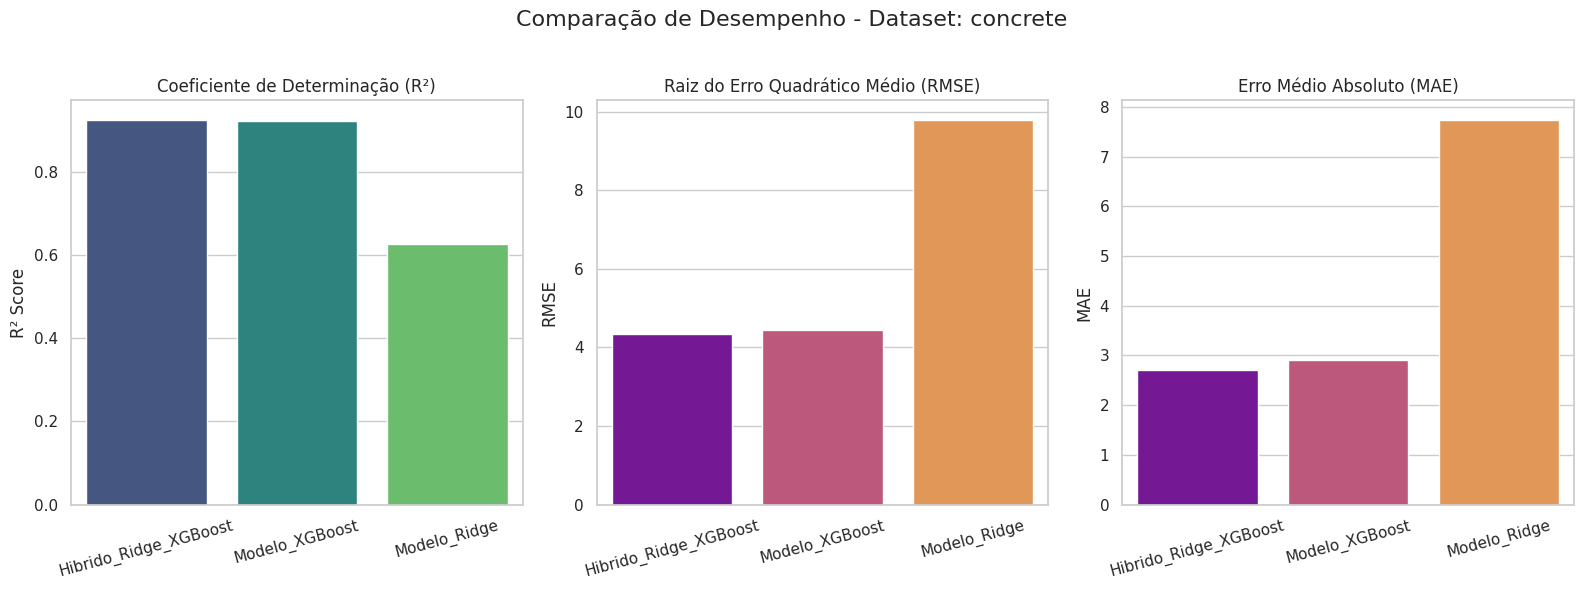

Gráfico de comparação de métricas salvo em: visual_analysis_report/concrete__01_metric_comparison.png


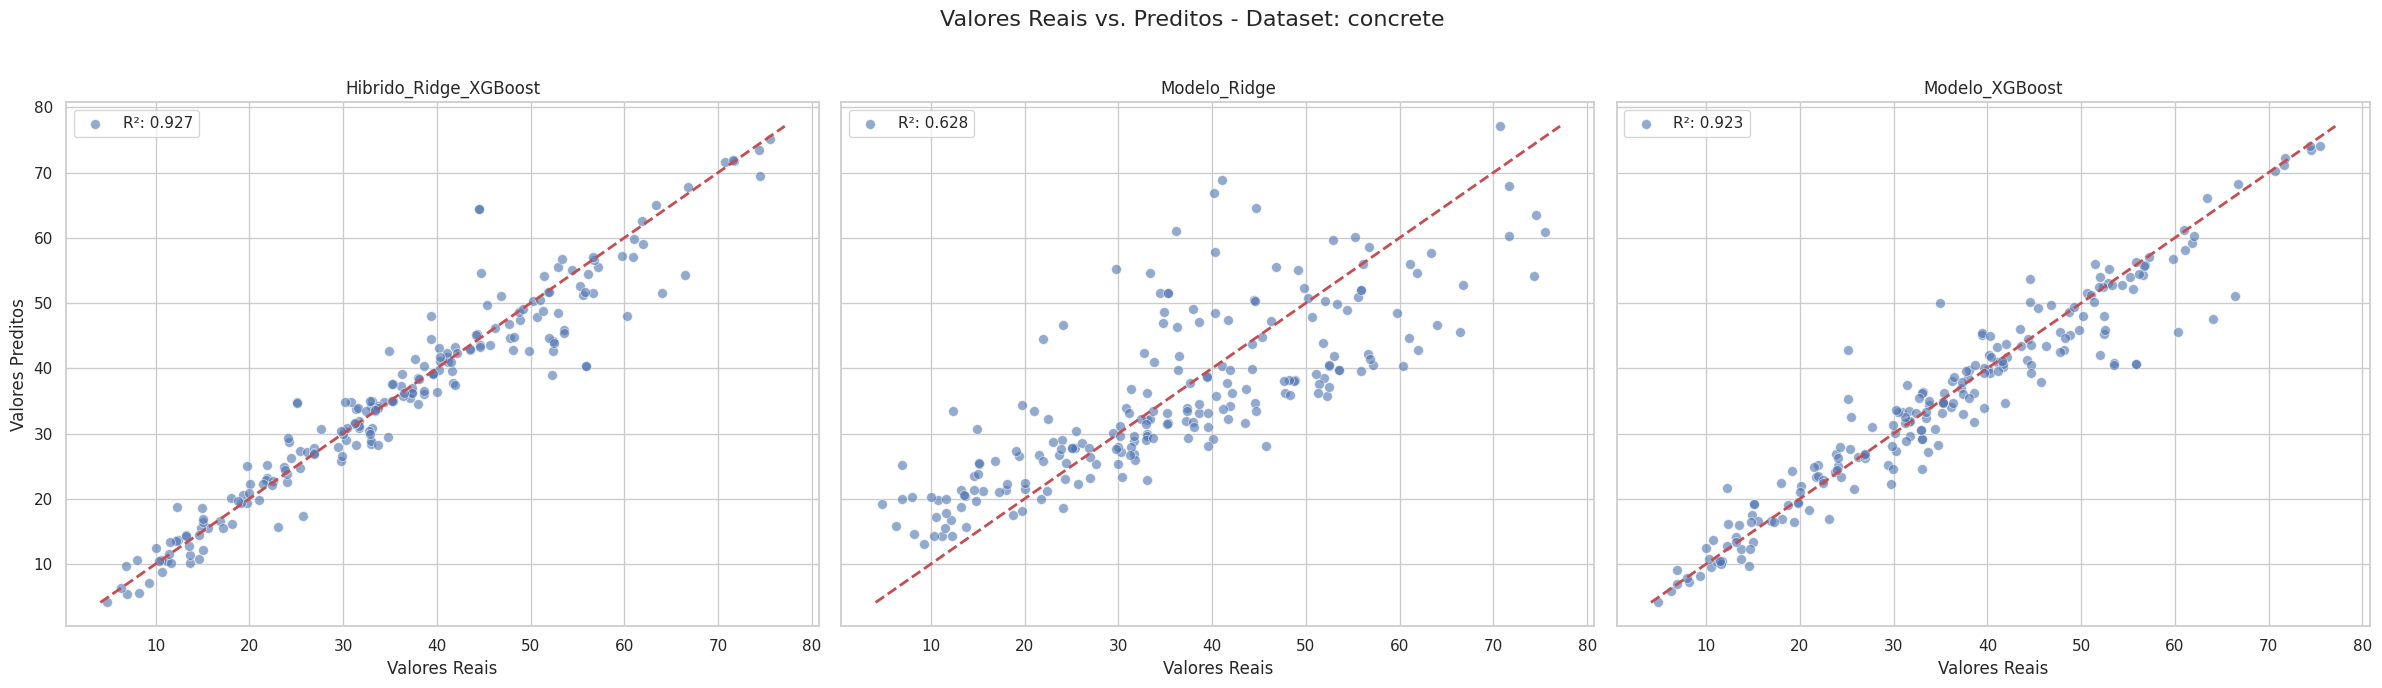

Gráfico Real vs. Predito salvo em: visual_analysis_report/concrete__02_real_vs_predicted.png


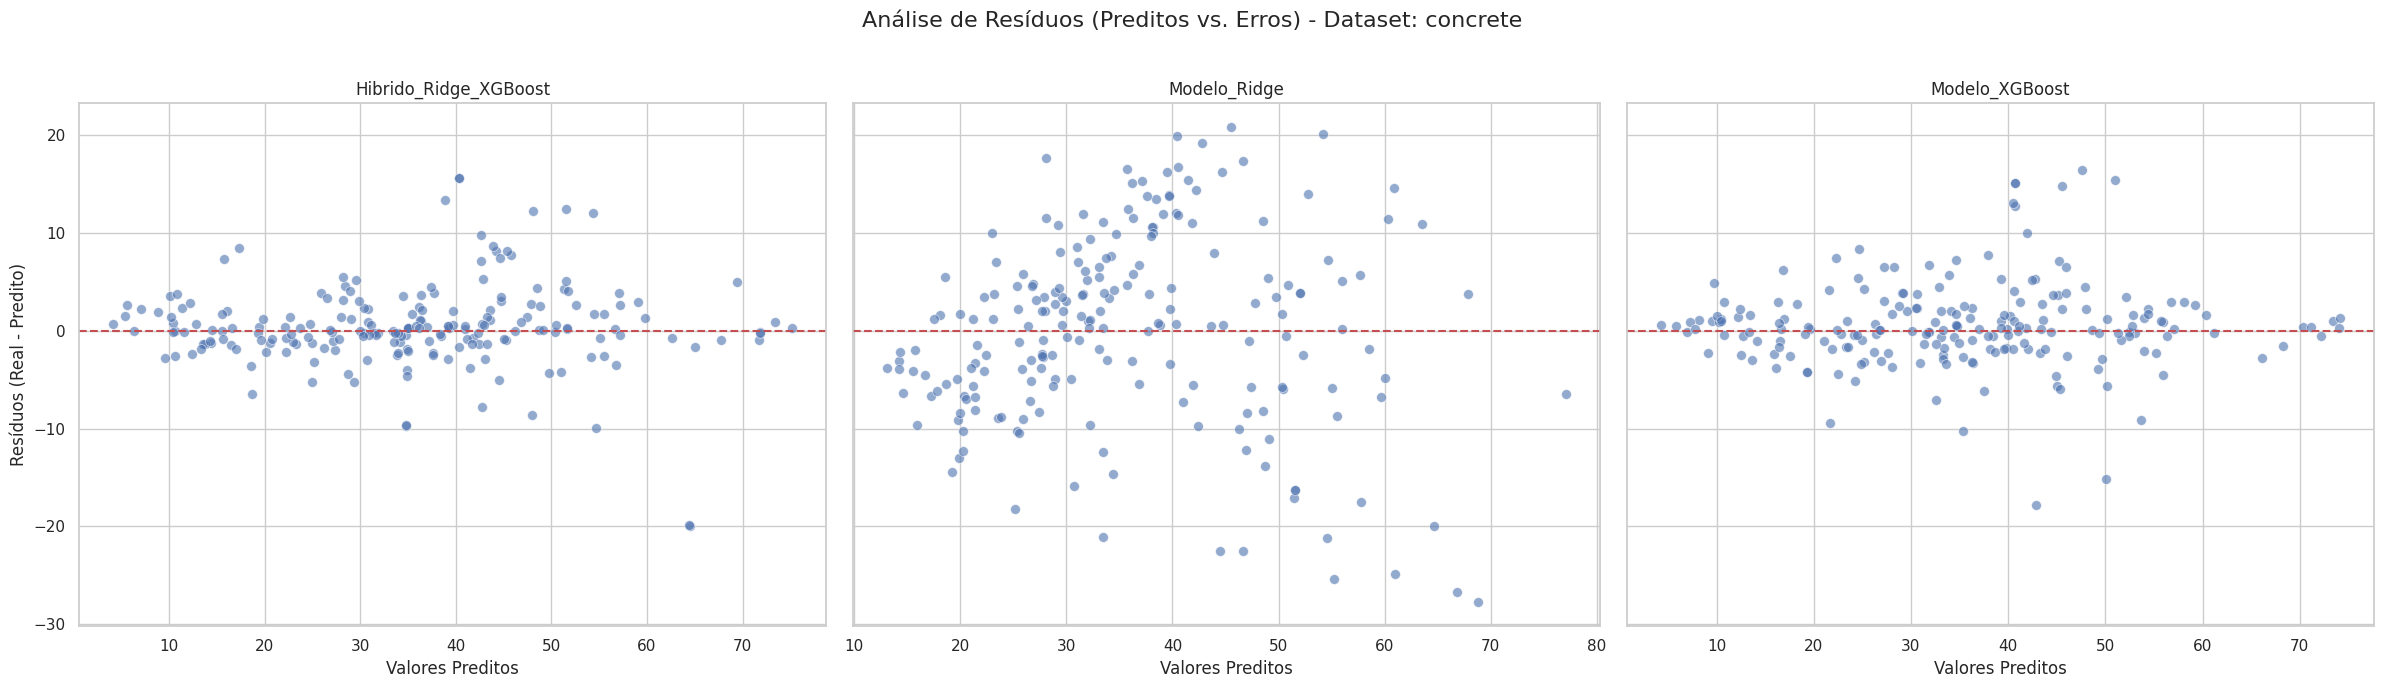

Gráfico de Resíduos salvo em: visual_analysis_report/concrete__03_residual_analysis.png
Gerando análise de distribuição de resíduos para: concrete...


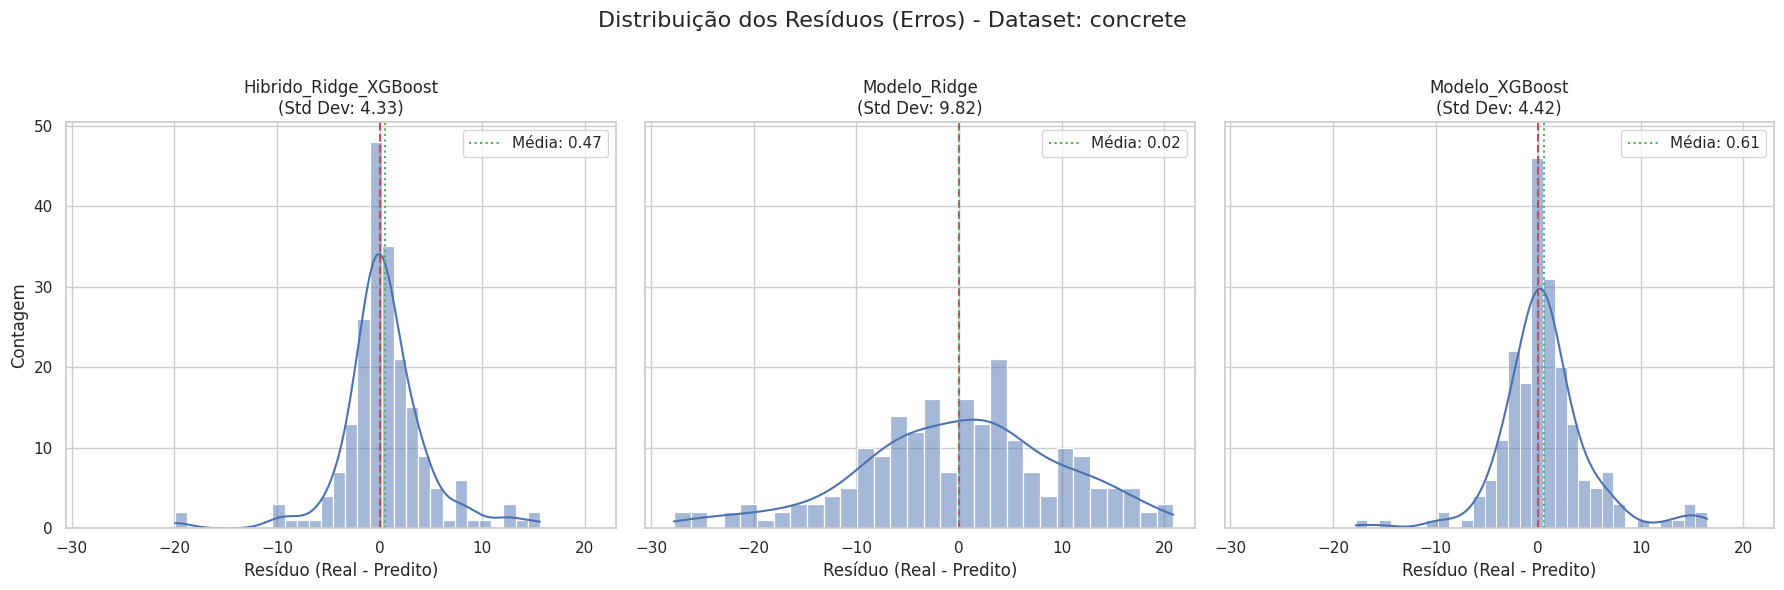

Gráfico de distribuição de resíduos salvo em: visual_analysis_report/concrete__04_residual_distribution.png

--- Análise Gráfica Concluída ---


In [25]:
# @title ## Análise Gráfica

print("Iniciando Estudo de Caso Visual...")
os.makedirs(VISUAL_REPORT_DIR, exist_ok=True)

# 1. Carregar os dados
print(f"Carregando dataset: '{DATASET_PARA_PLOTAR}'")
if DATASET_PARA_PLOTAR == 'friedman':
    X, y = load_friedman(n_samples=1000, noise=1.0)
elif DATASET_PARA_PLOTAR == 'concrete':
    X, y = load_concrete()
elif DATASET_PARA_PLOTAR == 'energy':
    X, y = load_energy()
else:
    raise ValueError(f"Dataset '{DATASET_PARA_PLOTAR}' não reconhecido.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# 2. Definir os modelos para comparação
models_to_plot = {}
for name, model_instance, _ in MODELOS:
    models_to_plot[name] = clone(model_instance)

# 3. Treinar modelos e coletar resultados
results = {}
predictions = {}
print("\n--- Treinando Modelos para Estudo de Caso ---")
for name, model in models_to_plot.items():
    print(f"Treinando {name}...")
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        results[name] = evaluate_regression(y_test, y_pred)
    except Exception as e:
        print(f"ERRO ao treinar o modelo {name}: {e}")

# Transformar resultados em um DataFrame para facilitar a plotagem
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
print("\n--- Resultados do Estudo de Caso ---")
display(results_df)

# ==============================================================================
# 4. PLOTAGEM DOS GRÁFICOS (Chamando as funções da Célula 1)
# ==============================================================================

if not results_df.empty:
    print("\n--- Gerando Gráficos ---")

    # Gráfico 1: Comparação de Métricas
    plot_metric_comparison(results_df, DATASET_PARA_PLOTAR, VISUAL_REPORT_DIR)

    # Gráfico 2: Real vs. Predito
    plot_real_vs_predicted(predictions, y_test, results, DATASET_PARA_PLOTAR, VISUAL_REPORT_DIR)

    # Gráfico 3: Análise de Resíduos
    plot_residual_analysis(predictions, y_test, DATASET_PARA_PLOTAR, VISUAL_REPORT_DIR)

    # Gráfico 4: Distribuição dos Resíduos
    plot_residual_distribution(predictions, y_test, DATASET_PARA_PLOTAR, VISUAL_REPORT_DIR)

    print("\n--- Análise Gráfica Concluída ---")
else:
    print("\nNenhum resultado para plotar. Verifique os erros de treinamento.")

Gerando análise de features para o dataset: concrete...


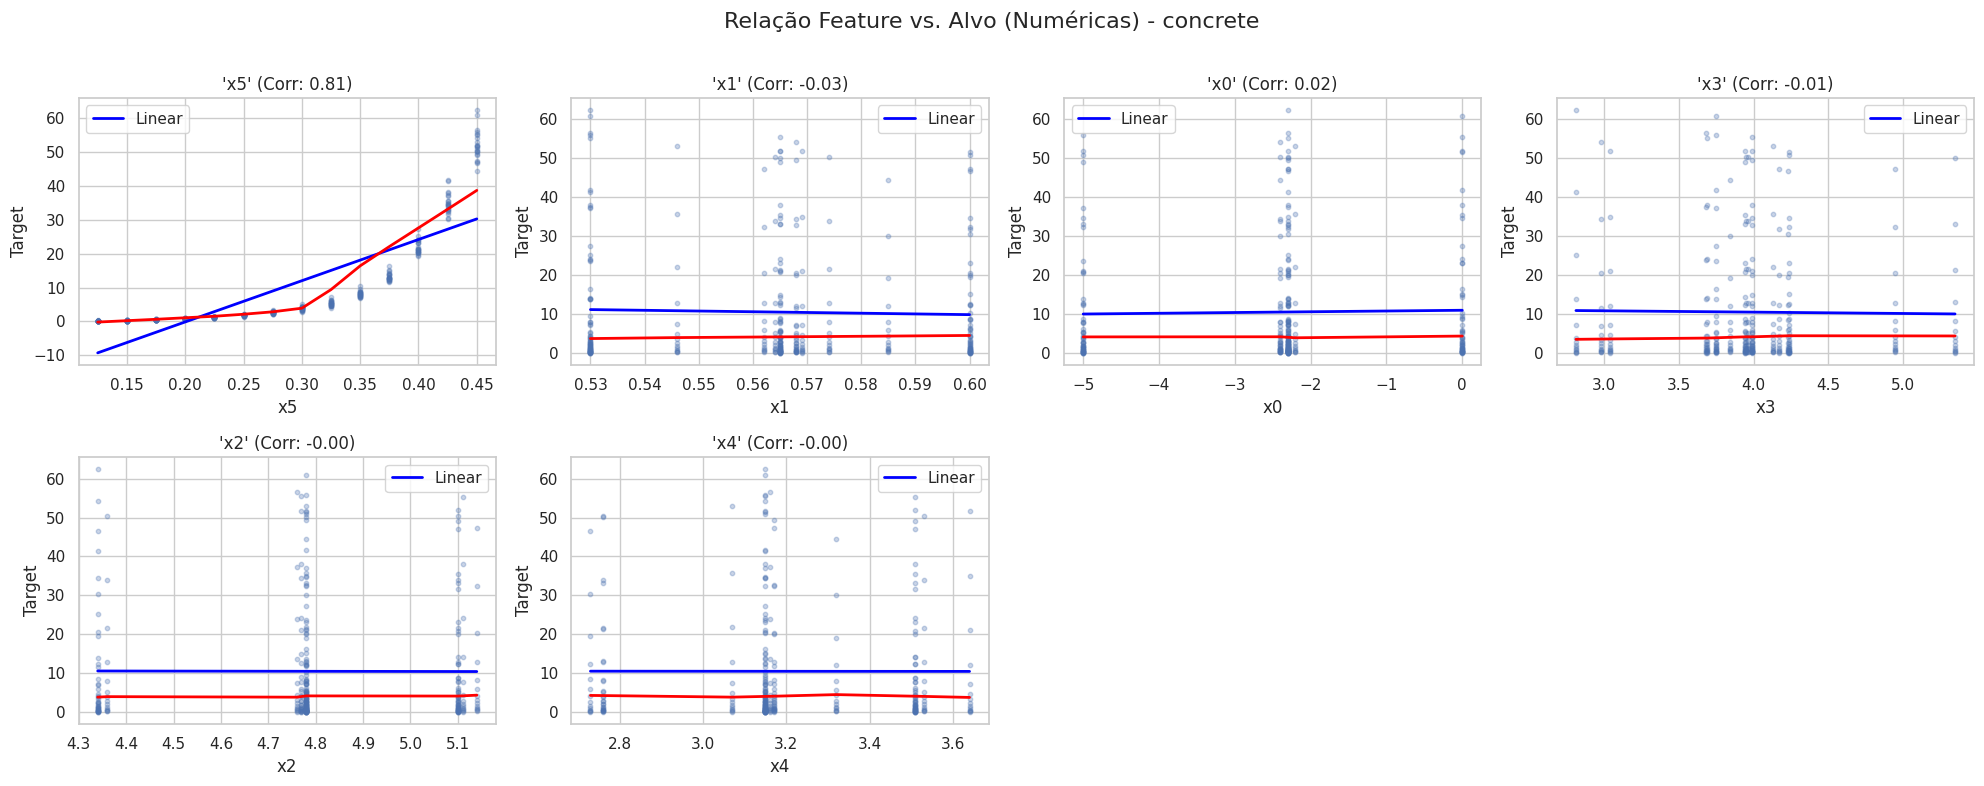

Gráfico de features numéricas salvo em: visual_analysis_report/concrete__00_numeric_features.png


In [26]:
X, y = load_yacht()

os.makedirs(VISUAL_REPORT_DIR, exist_ok=True)
plot_feature_target_relations(X, y, DATASET_PARA_PLOTAR, VISUAL_REPORT_DIR, n_top_features=12)

Gerando análise de features para o dataset: concrete...


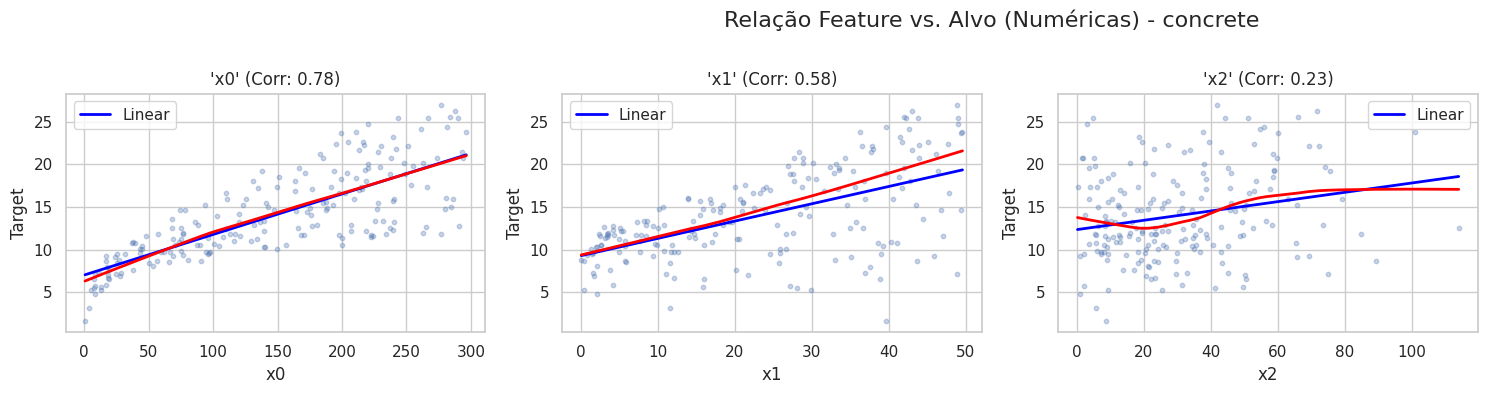

Gráfico de features numéricas salvo em: visual_analysis_report/concrete__00_numeric_features.png


In [27]:
X, y = load_advertising()

os.makedirs(VISUAL_REPORT_DIR, exist_ok=True)
plot_feature_target_relations(X, y, DATASET_PARA_PLOTAR, VISUAL_REPORT_DIR, n_top_features=12)